In [1]:
import sys
from pathlib import Path
sys.path = list(set(sys.path + ["../python"]))

In [19]:
import numpy as np
import pandas as pd

from scipy.special import logsumexp
from scipy.stats import multivariate_normal

import matplotlib

import seaborn as sns

In [3]:
# matplotlib.use('qt5agg')

In [12]:
from gaussian_system import wang_landau, System, time_matrix
from gaussian_system.wang_landau import energy_histogram, wang_landau_jit
from gaussian_system.thermodynamic_integration import estimate_marginal_density

In [5]:
from matplotlib import pyplot as plt

In [6]:
path = Path.cwd().parent / "plots" / "wang_landau"
assert path.exists()
path

PosixPath('/Users/mr/Git/Gillespie/plots/wang_landau')

In [7]:
system = System(lamda = 0.005, kappa = 0.25, rho = 0.01, mu = 0.01)

In [8]:
n_dim = 50
delta_t = 0.1
t = time_matrix(n_dim, delta_t)
initial_configuration = multivariate_normal(cov=system.corr_z(t)).rvs(1)
initial_configuration.reshape((2, -1))

array([[ 9.89484624,  9.80090313,  9.37966127,  9.36402404,  9.31776764,
         9.06106822,  8.89443123,  8.92132179,  8.6204098 ,  8.29754773,
         8.61614434,  8.43853766,  8.34405313,  8.44288804,  8.81574591,
         8.96129711,  8.91544425,  9.25168454,  9.41130596,  9.11768368,
         8.93958545,  8.76760243,  8.54151566,  8.77440367,  8.46778607,
         8.76823811,  8.80244983,  8.9393329 ,  8.65855797,  9.2431123 ,
         8.54296455,  8.5172313 ,  8.78212007,  9.16459228,  9.38696644,
         9.15433281,  9.0065639 ,  8.62925107,  8.50261899,  8.54852335,
         8.97822472,  8.82733009,  8.88125693,  9.1899779 ,  9.30471997,
         9.55780503,  9.73816795,  9.92229398,  9.65595763,  9.2080112 ],
       [-8.74630898, -8.87993919, -8.26454829, -8.39677065, -8.13204963,
        -8.34058372, -9.1502609 , -8.82638663, -9.08964743, -8.74421953,
        -9.14709427, -9.31237401, -9.44500884, -9.15492142, -9.20103373,
        -8.90333967, -8.79632824, -8.25080121, -8.

In [9]:
dicts = []
for _ in range(5):
    dicts.append(estimate_marginal_density(initial_configuration, 1000, system, t, 1.8, equilibrate=1000))
    
df = pd.concat(dicts)
df

1000it [00:10, 91.01it/s]
1000it [00:11, 90.41it/s]
1000it [00:11, 90.10it/s]
1000it [00:11, 89.82it/s]
1000it [00:11, 89.76it/s]


,log_likelihood,acceptance_rates,time,scale,skip,theta
0,-25.870510,0.419639,13.681855,1.8,1000,1.0
1,-25.824843,0.397614,13.681855,1.8,1000,1.0
2,-25.789031,0.407498,13.681855,1.8,1000,1.0
3,-25.759586,0.395101,13.681855,1.8,1000,1.0
4,-25.793409,0.400160,13.681855,1.8,1000,1.0
...,...,...,...,...,...,...
995,-26.505082,0.373832,11.143547,1.8,1000,1.0
996,-26.492004,0.377644,11.143547,1.8,1000,1.0
997,-26.430008,0.402901,11.143547,1.8,1000,1.0
998,-26.518209,0.395413,11.143547,1.8,1000,1.0


In [10]:
-logsumexp(-df.log_likelihood, b=1/len(df)), system.log_marginal(initial_configuration[n_dim:], t)[0]

NameError: name 'df' is not defined

In [15]:
from concurrent.futures import ProcessPoolExecutor

def estimate(theta):
    return estimate_marginal_density(initial_configuration, 3000, system, t, 1.2, equilibrate=2000, theta=theta)

dicts = []
with ProcessPoolExecutor() as executor:
    for result in executor.map(estimate, np.random.random_sample(20)):
        dicts.append(result)
    
df = pd.concat(dicts)
df

,log_likelihood,acceptance_rates,time,scale,skip,theta
0,-18.101795,0.731261,165.786877,1.2,2000,0.001333
1,-18.103328,0.695894,165.786877,1.2,2000,0.001333
2,-17.985397,0.705716,165.786877,1.2,2000,0.001333
3,-18.014694,0.680504,165.786877,1.2,2000,0.001333
4,-18.127597,0.698812,165.786877,1.2,2000,0.001333
...,...,...,...,...,...,...
2995,-16.419794,0.698568,87.715981,1.2,2000,0.420898
2996,-16.413447,0.711744,87.715981,1.2,2000,0.420898
2997,-16.424680,0.735024,87.715981,1.2,2000,0.420898
2998,-16.415619,0.681431,87.715981,1.2,2000,0.420898


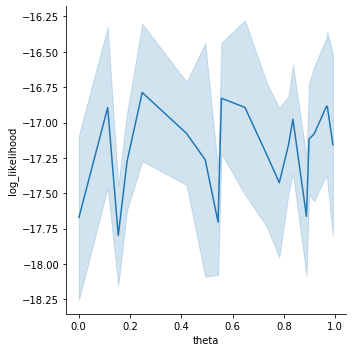

In [21]:
sns.relplot(x='theta', y='log_likelihood', kind='line', ci='sd', data=df)

In [23]:
df.log_likelihood.mean() / system.log_marginal(initial_configuration[n_dim:], t)[0]

1.0117350459200514

In [15]:
from gaussian_system.thermodynamic_integration import generate_samples_mcmc

samples, acceptance = generate_samples_mcmc(
    initial_conf=sample.reshape(-1), 
    num_samples=10000, 
    c_ss=system.corr_ss(t), 
    c_xs=system.corr_xs(t), 
    c_sx=system.corr_sx(t), 
    c_xx=system.corr_xx(t), 
    scale=3, 
    equilibrate=1000)

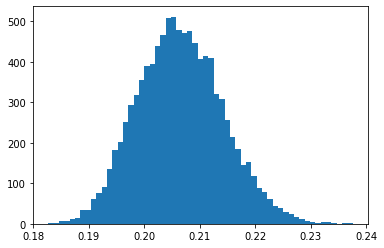

In [78]:
plt.hist(acceptance, bins='auto');

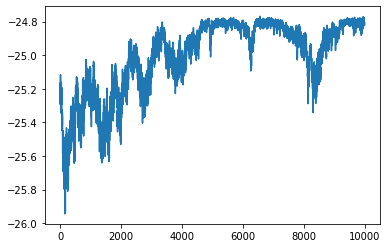

In [79]:
responses = samples[:,n_dim:]
signals = samples[:, :n_dim]
likelihoods = system.log_likelihood(responses, signals, t)
plt.plot(likelihoods);

In [80]:
-logsumexp(-likelihoods[2000:], b=1/len(likelihoods[2000:])), system.log_marginal(response, t)[0]

(-24.926927458256795, -24.969954287481386)

In [24]:
signals

array([[ -8.34672136,  -8.5109831 ,  -8.40525488, ...,  -8.22664924,
         -8.10402489,  -8.05800416],
       [ -8.4439354 ,  -8.249945  ,  -7.98261291, ...,  -8.40160661,
         -8.55982509,  -8.17930201],
       [ -6.8191121 ,  -7.1828851 ,  -7.64330531, ...,  -7.74005915,
         -7.90806569,  -8.05131323],
       ...,
       [-10.58869851, -10.81246106, -10.39358657, ..., -10.21390204,
         -9.95959749,  -9.88549831],
       [ -9.95035833,  -9.77983835,  -9.64018435, ...,  -9.56760008,
         -9.47873068,  -9.42243444],
       [ -9.00483364,  -9.05648871,  -9.35451295, ...,  -9.83354025,
        -10.17231022, -10.4279657 ]])

(100, 100)

In [17]:
initial_energy = system.energy(signal, response, t)[0]
peak_energy = system.energy(system.peak_s(response, t), response, t)[0]

In [64]:
bins = np.linspace(peak_energy+1, initial_energy + 0.5*(initial_energy - peak_energy), 51)
bins

array([229.16561725, 230.06320062, 230.96078399, 231.85836736,
       232.75595073, 233.65353409, 234.55111746, 235.44870083,
       236.3462842 , 237.24386756, 238.14145093, 239.0390343 ,
       239.93661767, 240.83420104, 241.7317844 , 242.62936777,
       243.52695114, 244.42453451, 245.32211788, 246.21970124,
       247.11728461, 248.01486798, 248.91245135, 249.81003472,
       250.70761808, 251.60520145, 252.50278482, 253.40036819,
       254.29795156, 255.19553492, 256.09311829, 256.99070166,
       257.88828503, 258.78586839, 259.68345176, 260.58103513,
       261.4786185 , 262.37620187, 263.27378523, 264.1713686 ,
       265.06895197, 265.96653534, 266.86411871, 267.76170207,
       268.65928544, 269.55686881, 270.45445218, 271.35203555,
       272.24961891, 273.14720228, 274.04478565])

In [66]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
fig.show()

final_entropy = None

for hist, entropy in wang_landau_jit(
        response, signal, system.corr_z(t), 0.04, bins, 0.6, 0.9
    ):
        final_entropy = entropy
    
        ax.clear()
        ax2.clear()
        ax.plot(hist)
        ax2.plot(entropy, color='red')
        ax.set(ylim=(0, None))
        fig.canvas.draw_idle()
        try:
        # make sure that the GUI framework has a chance to run its event loop
        # and clear any GUI events.  This needs to be in a try/except block
        # because the default implementation of this method is to raise
        # NotImplementedError
            fig.canvas.flush_events()
        except NotImplementedError:
            pass
final_entropy

update f: 1.0 -> 0.5
update f: 0.5 -> 0.25
update f: 0.25 -> 0.125
update f: 0.125 -> 0.0625
update f: 0.0625 -> 0.03125


array([88509.5625, 93066.4375, 93103.    , 93155.625 , 93171.    ,
       93185.6875, 93203.1875, 93207.125 , 93214.1875, 93216.6875,
       93221.375 , 93223.0625, 93225.5625, 93227.625 , 93231.75  ,
       93232.125 , 93233.8125, 93236.5625, 93238.    , 93240.0625,
       93241.8125, 93242.875 , 93244.875 , 93246.8125, 93248.    ,
       93248.75  , 93250.1875, 93250.6875, 93253.0625, 93253.25  ,
       93254.6875, 93255.125 , 93256.0625, 93256.6875, 93257.375 ,
       93257.875 , 93258.875 , 93259.3125, 93259.5   , 93260.8125,
       93261.    , 93261.5   , 93262.1875, 93262.6875, 93263.4375,
       93263.25  , 93263.625 , 93263.5625, 93264.375 , 93264.5   ])

In [48]:
# wang_landau(response, signal, system, t, 0.01, bins, 0.6, 0.9)

In [76]:
energies = (bins[:-1] + bins[1:]) / 2
log_dos = entropy - logsumexp(final_entropy, b=np.diff(bins))
dos = np.exp(log_dos)

plt.plot(energies, dos)
plt.show()

In [73]:
logsumexp(-energies, b=dos * np.diff(bins)) / 2

-132.81244974310982

In [16]:
dos * np.diff(bins)

array([4.49061597e-19, 5.66283446e-05, 9.51748226e-03, 7.70268387e-03,
       2.49913532e-03, 3.74930607e-03, 1.05910494e-02, 7.10605849e-03,
       6.31631650e-03, 1.61192173e-02, 1.53714695e-02, 1.95715433e-02,
       2.18200138e-02, 1.48706741e-02, 1.45171334e-02, 2.16097163e-02,
       2.37188246e-02, 1.81745088e-02, 1.76043490e-02, 2.22400997e-02,
       2.83169461e-02, 4.88967731e-02, 3.60317279e-02, 3.80333482e-02,
       2.13214655e-02, 2.53040715e-02, 3.32408250e-02, 3.32200884e-02,
       4.50250158e-02, 3.47709309e-02, 2.01113171e-02, 2.87901603e-02,
       2.24078120e-02, 1.60041510e-02, 2.13550149e-02, 2.82731497e-02,
       2.55267279e-02, 2.08213111e-02, 2.30327130e-02, 2.33808307e-02,
       2.58640756e-02, 2.04474042e-02, 2.10833139e-02, 2.15698260e-02,
       2.08931504e-02, 1.96150543e-02, 1.20769457e-02, 8.55849452e-03,
       1.26407444e-02, 1.02304008e-02])

In [70]:
system.log_marginal(response, t)

array([-143.06752214])

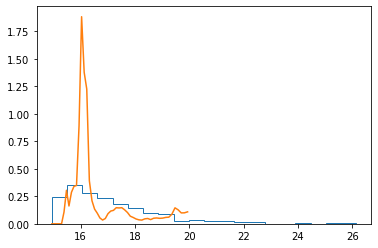

In [38]:
plt.hist(energy_histogram(response, system , t), bins=20, density=True, histtype="step")
plt.plot(energies, dos)

In [26]:
(hist_vals, hist_bins) = np.histogram(energy_histogram(response, system , t), bins='auto', density=True)

In [27]:
logsumexp(-(hist_bins[1:] + hist_bins[:-1]) / 2, b=np.diff(hist_bins) * hist_vals) / 2

-10.623391269721699

In [39]:
hist_vals

array([0.00457344, 0.01981825, 0.0396365 , 0.07927301, 0.08537093,
       0.10214022, 0.08994438, 0.0960423 , 0.08384645, 0.05183235,
       0.0320141 , 0.02286721, 0.02134273, 0.01676929, 0.00304896,
       0.00457344, 0.00304896, 0.00457344, 0.00152448])

In [42]:
system.log_prior(signal, t), system.log_likelihood(response, signal, t), system.log_marginal(response, t)

(array([-9.38666437]), array([-19.50144425]), array([-19.68305434]))

In [43]:
system.energy(signal, response, t)

array([28.88810862])